# Modelling Probabilily of Default using XGBoost
## Amy Fare -- 2025-04-17


In [14]:

# Import necessary libaries
import pandas as pd
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)



#### Data Loading

In [15]:
# Load the dataset
# Remove the nrows parameter to load the entire dataset -- more data is better right???
url = 'https://github.com/Safa1615/Dataset--loan/blob/main/bank-loan.csv?raw=true'
data = pd.read_csv(url)

# Save rows with NaN default to a separate "unknown" dataset
unknown_data = data[data['default'].isna()]

# Drop rows with NaN default from the main dataset
data = data.dropna(subset=['default'])

# Split the data into features (independent variables) and the target variable (default or not)
X = data.drop('default', axis=1)
y = data['default']

#### Data Exploration

Features:
age           int64
ed            int64
employ        int64
address       int64
income        int64
debtinc     float64
creddebt    float64
othdebt     float64
dtype: object

Correlation of each feature with the target variable:
age        -0.137657
ed          0.114676
employ     -0.282978
address    -0.164451
income     -0.070970
debtinc     0.389575
creddebt    0.244740
othdebt     0.145713
dtype: float64


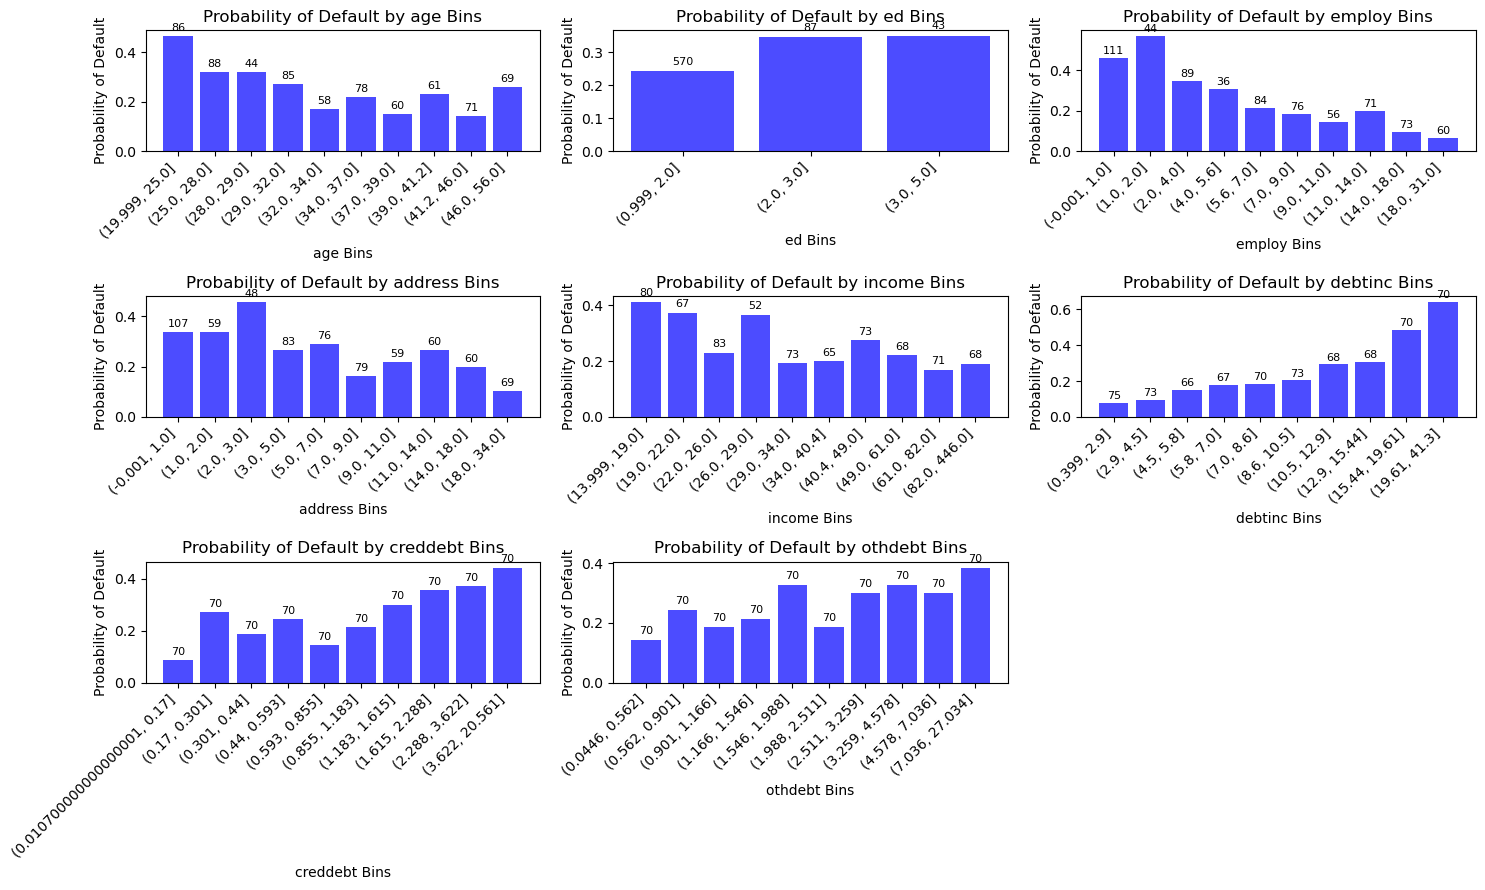

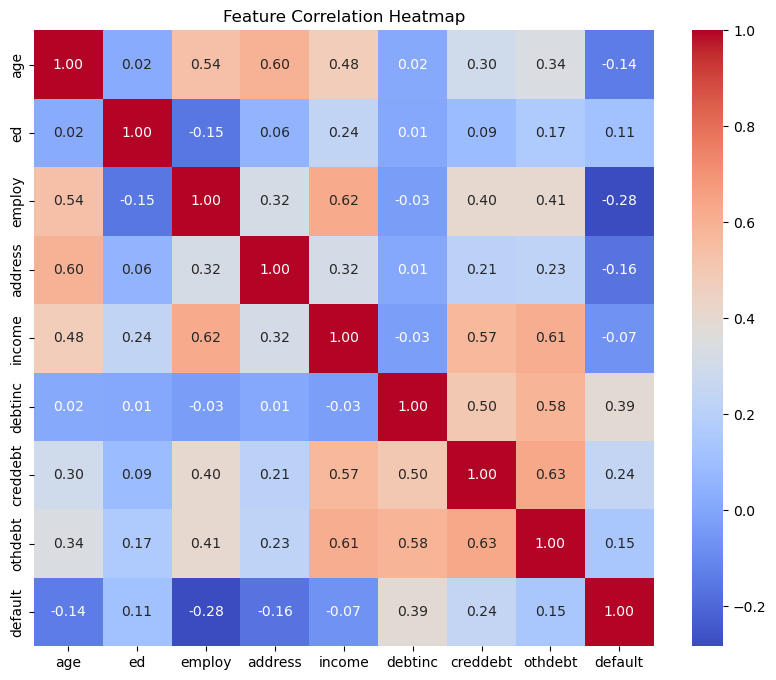

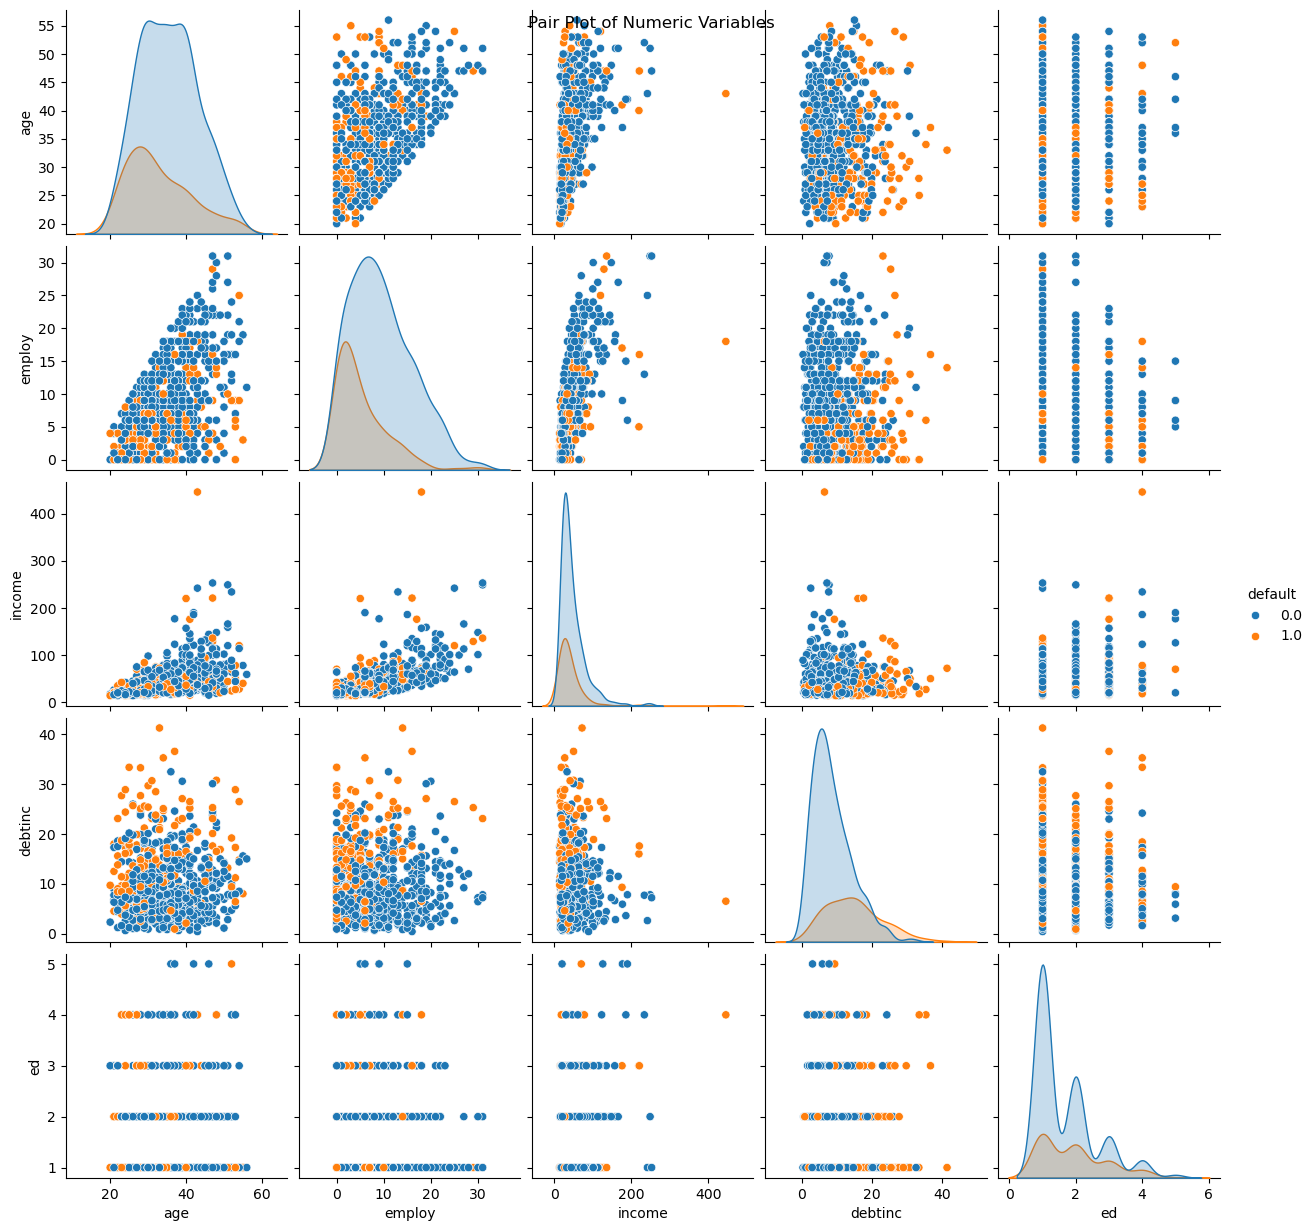

In [16]:
# List the data type of each feature
feature_types = X.dtypes
print("Features:")
print(X.dtypes)

# Calculate correlation strength of each feature with the target variable
correlations = X.corrwith(y)
print("\nCorrelation of each feature with the target variable:")
print(correlations)

# Iterate through each feature and plot probability of default
# Define the number of rows and columns for the grid
num_cols = 3
num_rows = (len(X.columns) + num_cols - 1) // num_cols

# Create a figure and axes for the grid
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 3 * num_rows))  # Reduced vertical size
axes = axes.flatten()

# Iterate through each feature and plot probability of default
for i, feature in enumerate(X.columns):
    # Use quantile-based binning to ensure equal number of samples in each bin
    data['bin'] = pd.qcut(data[feature], q=10, duplicates='drop')  # 10 bins for better granularity
    bin_summary = data.groupby('bin')['default'].agg(['mean', 'count']).reset_index()
    bin_summary.columns = ['bin', 'prob_default', 'count']
    
    ax = axes[i]
    bin_summary['bin'] = bin_summary['bin'].astype(str)  # Convert intervals to strings
    ax.bar(bin_summary['bin'], bin_summary['prob_default'], alpha=0.7, color='blue', label='Probability of Default')
    ax.set_xticklabels(bin_summary['bin'], rotation=45, ha='right')
    ax.set_xlabel(f'{feature} Bins')
    ax.set_ylabel('Probability of Default')
    ax.set_title(f'Probability of Default by {feature} Bins')
    
    # Add labels for the number of samples in each bin
    for idx, row in bin_summary.iterrows():
        if row['count'] > 0:  # Only label if count is greater than 0
            ax.text(idx, row['prob_default'] + 0.02, f"{row['count']}", ha='center', fontsize=8, color='black')

# Remove any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

data = data.drop(columns=['bin'])


# Create a heatmap to visualize correlation between features
correlation_matrix = data.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Feature Correlation Heatmap")
plt.show()

# Create a pair plot to visualize relationships between features
sns.pairplot(data, vars=['age', 'employ', 'income', 'debtinc','ed'], hue='default')
plt.suptitle("Pair Plot of Numeric Variables")
plt.show()


| Feature   | Strength of Correlation with Default Probability | Observation                                                                 |
|-----------|-----------------------|-----------------------------------------------------------------------------|
| age       | -0.14                | Probability of default decreases with age, but sharp increase in upper bin. Possible reasons: early retirement or poor sampling. |
| ed        | 0.11                 | No obvious trend. Lower education levels may have stricter approval criteria, leading to less default. Small sample size for ed=5 (likely PhD). |
| employ    | -0.28                | Longer employment duration correlates with lower default probability, but sharp increase after 25 years. Possible reasons: retirement or other factors. |
| address   | -0.16                | Longer address duration correlates with lower default probability. Upper bins have small sample sizes, so trends may not be reliable. |
| income    | -0.07                | Higher income correlates with lower default probability. The trend is consistent but weak. |
| debtinc   | 0.39                 | Higher debt-to-income ratio strongly correlates with higher default probability. **This is a key feature** |
| creddebt  | 0.24                 | Higher credit debt correlates with higher default probability. Moderate correlation strength. |
| othdebt   | 0.15                 | Higher other debt correlates with higher default probability. Weak correlation but still notable. |

**I think the key features will be debtinc, employ, and creddebt, in that order.**

#### Data Cleaning/Splitting/Preprocessing

I don't see any need to scale the features, they're all in logical-looking units already

In [17]:
# Check for missing values in the dataset
missing_values = data.isnull().sum()
#print("Missing values in each column:")
#print(missing_values)
# No missing values...

# No trend for education so create a reduced dataset excluding it
# I did some trial and error excluding each feature; only exclusion of ed improved the results
important_features = ['debtinc','age', 'address', 'employ', 'income', 'creddebt', 'othdebt']
reduced_data = data[important_features + ['default']].copy()
reduced_X = reduced_data.drop('default', axis=1)
reduced_y = reduced_data['default']

# Split the full dataset into training and testing sets
X_train_full, X_test_full, y_train_full, y_test_full = train_test_split(X, y, test_size=0.2, random_state=42)

# Split the reduced dataset into training and testing sets
X_train_reduced, X_test_reduced, y_train_reduced, y_test_reduced = train_test_split(reduced_X, reduced_y, test_size=0.2, random_state=42)

# Define a function to calculate and print mean feature values and default proportion
def print_metrics(data, labels, dataset_name):
    metrics = {
        'debtinc': data['debtinc'].mean(),
        'age': data['age'].mean(),
        'address': data['address'].mean(),
        'employ': data['employ'].mean(),
        'income': data['income'].mean(),
        'creddebt': data['creddebt'].mean(),
        'othdebt': data['othdebt'].mean(),
        'default': labels.mean()
    }
    print(f"Metrics for {dataset_name}:")
    for key, value in metrics.items():
        print(f"  {key}: {value:.2f}")
    print()

# Reduced dataset metrics
print_metrics(X_train_reduced, y_train_reduced, "Reduced Training Set")
print_metrics(X_test_reduced, y_test_reduced, "Reduced Test Set")

Metrics for Reduced Training Set:
  debtinc: 10.31
  age: 34.85
  address: 8.45
  employ: 8.30
  income: 45.59
  creddebt: 1.53
  othdebt: 3.04
  default: 0.26

Metrics for Reduced Test Set:
  debtinc: 10.06
  age: 34.89
  address: 7.60
  employ: 8.74
  income: 45.64
  creddebt: 1.67
  othdebt: 3.13
  default: 0.27



#### Model Training

##### Basic model with "first guess" parameters, comparing full dataset vs. reduced columns

In [18]:
######################
# Model Initialization
######################

# Initialize the XGBoost classifier with default parameters -- calling this "basic" to avoid confusion
classifier_full = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42, max_depth=3, learning_rate=0.1)

# Initialize the XGBoost classifier with default parameters for reduced dataset
classifier_reduced = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42, max_depth=3, learning_rate=0.1)

################
# Model Training
################

# Train the classifier on the full training data
classifier_full.fit(X_train_full, y_train_full)

# Train the classifier on the reduced training data
classifier_reduced.fit(X_train_reduced, y_train_reduced)

#################################
# Model Prediction and Evaluation
#################################

# Make predictions using the basic model on the full dataset
y_pred_full = classifier_full.predict(X_test_full)

# Evaluate the model
accuracy_full = accuracy_score(y_test_full, y_pred_full)
confusion_full = confusion_matrix(y_test_full, y_pred_full)
classification_rep_full = classification_report(y_test_full, y_pred_full)

# Display the results
print("Results for Full Dataset with Basic Model:")
print(f"Accuracy: {accuracy_full: .2f}")
print("Confusion Matrix:")
print(confusion_full)
print("Classification Report:")
print(classification_rep_full)

# Make predictions using the default model on the reduced dataset
y_pred_reduced = classifier_reduced.predict(X_test_reduced)

# Evaluate the model
accuracy_reduced = accuracy_score(y_test_reduced, y_pred_reduced)
confusion_reduced = confusion_matrix(y_test_reduced, y_pred_reduced)
classification_rep_reduced = classification_report(y_test_reduced, y_pred_reduced)

# Display the results
print("Results for Reduced Dataset with Basic Model:")
print(f"Accuracy: {accuracy_reduced: .2f}")
print("Confusion Matrix:")
print(confusion_reduced)
print("Classification Report:")
print(classification_rep_reduced)

Results for Full Dataset with Basic Model:
Accuracy:  0.79
Confusion Matrix:
[[95  7]
 [22 16]]
Classification Report:
              precision    recall  f1-score   support

         0.0       0.81      0.93      0.87       102
         1.0       0.70      0.42      0.52        38

    accuracy                           0.79       140
   macro avg       0.75      0.68      0.70       140
weighted avg       0.78      0.79      0.77       140

Results for Reduced Dataset with Basic Model:
Accuracy:  0.81
Confusion Matrix:
[[96  6]
 [21 17]]
Classification Report:
              precision    recall  f1-score   support

         0.0       0.82      0.94      0.88       102
         1.0       0.74      0.45      0.56        38

    accuracy                           0.81       140
   macro avg       0.78      0.69      0.72       140
weighted avg       0.80      0.81      0.79       140



So we can see that: 
* XGBoost is better than random forest by all measures.
* Removing the education feature improves the XGBoost fit by all measures.

##### Hyperparameter tuning using GridSearchCV

In [19]:
######################
# Model Initialization
######################
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

#################################
# Model Training with Grid Search
#################################

# Define the parameter grid for XGBClassifier
param_grid = {
    'max_depth': [3, 4],
    'learning_rate': [0.01, 0.04, 0.05, 0.06, 0.075, 0.1, 0.125],
    'subsample': [0.5, 0.6, 0.64, 0.65, 0.66, 0.7, 0.75, 0.8],
}

# Use f1_micro score as the scoring metric for the grid search. 
# f1_micro balances precision and recall, and calculates metrics globally.
# Use 3-fold cross-validation for the grid search
grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid, scoring='f1_micro', cv=3)
grid_search.fit(X_train_reduced, y_train_reduced)

# Get the best parameters and best estimator
best_params = grid_search.best_params_
best_classifier = grid_search.best_estimator_

#################################
# Model Prediction and Evaluation
#################################

# Make predictions using the best model
y_pred_reduced = best_classifier.predict(X_test_reduced)

# Evaluate the model
accuracy_reduced = accuracy_score(y_test_reduced, y_pred_reduced)
confusion_reduced = confusion_matrix(y_test_reduced, y_pred_reduced)
classification_rep_reduced = classification_report(y_test_reduced, y_pred_reduced)

# Display the results
print("Best Parameters from Grid Search:")
print(best_params)

print("Results for Reduced Dataset with Best Parameters:")
print(f"Accuracy: {accuracy_reduced: .2f}")
print("Confusion Matrix:")
print(confusion_reduced)
print("Classification Report:")
print(classification_rep_reduced)

Best Parameters from Grid Search:
{'learning_rate': 0.05, 'max_depth': 3, 'subsample': 0.65}
Results for Reduced Dataset with Best Parameters:
Accuracy:  0.83
Confusion Matrix:
[[97  5]
 [19 19]]
Classification Report:
              precision    recall  f1-score   support

         0.0       0.84      0.95      0.89       102
         1.0       0.79      0.50      0.61        38

    accuracy                           0.83       140
   macro avg       0.81      0.73      0.75       140
weighted avg       0.82      0.83      0.81       140



##### Interpretation of model performance

For the default class, the "best parameters" model has a 50/50 chance to correctly identify default (i.e. recall).

For the non-default class, it has a 5% chance to incorrectly predict default (false positive). This is marginally better than the 6% chance using the basic parameters.

##### Comparing grid search best parameters vs. basic "first-guess" parameters

**Grid Search Best Parameters (Reduced Dataset):**
```
              precision    recall  f1-score   support
         0.0       0.84      0.95      0.89       102
         1.0       0.79      0.50      0.61        38
    accuracy                           0.83       140
   macro avg       0.81      0.73      0.75       140
weighted avg       0.82      0.83      0.81       140
```

**Basic Model (Reduced Dataset):**
```
              precision    recall  f1-score   support
         0.0       0.82      0.94      0.88       102
         1.0       0.74      0.45      0.56        38
    accuracy                           0.81       140
   macro avg       0.78      0.69      0.72       140
weighted avg       0.80      0.81      0.79       140
```

**Grid Search Best Parameters -- improvements over basic model:**
1. **Improved Recall for Default Class (1)**: The grid search model is better at identifying actual defaults (50% vs. 45%).
2. **Improved F1-Score for Default Class (1)**: The balance between precision and recall is better for the default class (0.61 vs. 0.56).
3. **Higher Overall Accuracy**: The grid search model achieves 83% accuracy compared to 81% for the basic model.
4. **Better Macro and Weighted Averages**: The grid search model has higher macro and weighted averages for precision, recall, and F1-score.

**Conclusion:**
The **grid search best parameters model** is the better choice by all measures, significantly improving recall, F1-score, and overall accuracy, making it more effective for credit risk prediction where identifying defaults is critical.

#### Model deployment: Predicting default for dataset rows with unknown default

In [20]:
# Column reduction for unknown data
unknown_features = unknown_data[reduced_X.columns]

# Predict default using the best_classifier
predicted_default = best_classifier.predict(unknown_features)

# Add predictions to the unknown_data DataFrame
unknown_data['predicted_default'] = predicted_default

# Display the updated unknown_data DataFrame including predictions
# print(unknown_data.to_string())

#### Reflection & Comments

##### Notes & Comments

**Science & Business**

Model selection & tuning blends science and business, and the final selection is a business decision. Sure, some models/parameters are objectively better than others, so the process starts with eliminating the bad ones. But eventually I reached a point where I had a few options that perform similarly, e.g. one had slightly better recall while the other had slightly better precision. At that point, it's a business decision:
* If financial conditions are tight, I would select the model with the best recall, to miminize default risk. 
* If I'm flush with investable cash, I might select a model with better precision at the expense of slightly worse recall, because this increases profit and I can take a loss or two.

**Hyperparameter tuning**

I played a lot with hyperparameter tuning. Experimented with a wider range of hyperparameters, and more different scoring metrics, than what's shown here.
* I think f1 scoring is most appropriate for the grid search in this case. I tried both `f1` (unweighted average across classes) and `f1_micro` (global count of TP/FN/FP). I think `f1` should be better, because of our unbalanced classes. 
* I expected that, compared to `f1`, `f1_micro` would result in better f1 scores for non-default and maybe worse for default. But I was surprised to find that `f1_micro` had better test results across the board for both classes. 
* So that left me wondering, why didn't the `f1` grid search select the same parameters as `f1_micro`? **Why did the parameters selected by `f1` grid search perform worse on the test data?** If I saw this in a real-life scenario, I would definitely investigate further:
    * Does the distribution of test data differ from the training data? I did check the proportion of default and the feature averages, they look roughly similar. But perhaps the distribution is different, e.g. variance/skew etc.
    * Do the `f1` parameters perform better than `f1_micro` if we use a larger test dataset?

**Other models?**

Maybe later I will experiment with other models, see if I can get recall above 50%. Would love to get my hands on a larger/realer dataset.

##### Random Forest vs. XGBoost

**Random Forest**:
- Random Forest is an ensemble learning method that builds multiple decision trees and combines their outputs to improve accuracy and reduce overfitting.
- It uses bagging (bootstrap aggregation) to train each tree on a random subset of the data and features.
- It is relatively simple to implement and works well with default hyperparameters.
- Use cases: Random Forest is effective for tabular data, classification, regression, and feature importance analysis.

**XGBoost**:
- XGBoost (Extreme Gradient Boosting) is a gradient boosting algorithm that builds trees sequentially, where each tree corrects the errors of the previous one.
- It uses advanced techniques like regularization, weighted quantile sketch, and parallel processing to improve performance and prevent overfitting.
- It requires careful hyperparameter tuning but often achieves higher accuracy than Random Forest.
- Use cases: XGBoost is widely used in machine learning competitions and real-world applications for structured/tabular data, especially when high accuracy is required.

**Comparison**:
| Feature                | Random Forest                          | XGBoost                              |
|------------------------|----------------------------------------|--------------------------------------|
| **Algorithm**          | Bagging                               | Gradient Boosting                   |
| **Training**           | Parallel (independent trees)          | Sequential (trees depend on previous) |
| **Overfitting Control**| Implicit (averaging trees)             | Explicit (regularization)           |
| **Speed**              | Faster for large datasets             | Slower due to sequential training   |
| **Hyperparameters**    | Fewer, easier to tune                 | Many, requires careful tuning       |
| **Performance**        | Good baseline                         | Often better with proper tuning     |

**Why XGBoost Performed Better**:
1. **Regularization**: XGBoost's regularization techniques (e.g., L1/L2 penalties) helped prevent overfitting, especially given the small dataset size.
2. **Gradient Boosting**: By focusing on correcting errors from previous trees, XGBoost captured complex patterns in the data more effectively.
3. **Hyperparameter Tuning**: The grid search optimized key parameters like `max_depth`, `learning_rate`, and `subsample`, improving model performance.
4. **Feature Importance**: XGBoost leveraged the most important features (e.g., `debtinc`, `creddebt`) more effectively, as seen in the reduced dataset results.

In summary, XGBoost's advanced capabilities and optimized hyperparameters made it a better fit for our dataset, achieving higher accuracy and better recall for the default class.

##### Implications of Using XGBoost in Credit Risk Prediction

Here's a non-exhaustive list of characteristics that make XGBoost particularly well-suited for credit risk prediction:

1. **Improved Accuracy**: XGBoost captures complex patterns in data, leading to higher accuracy in predicting credit defaults compared to simpler models like Random Forest.

2. **Feature Importance**: It highlights key drivers of credit risk, such as `debtinc` and `creddebt`, enabling financial institutions to make data-driven decisions.

3. **Handling Imbalanced Data**: XGBoost's ability to optimize for specific metrics (e.g., F1-score) makes it effective for datasets with fewer defaults than non-defaults.

4. **Regularization**: Built-in L1/L2 penalties prevent overfitting, ensuring the model generalizes well to unseen data.

5. **Business Impact**: By improving recall for the default class, XGBoost minimizes the risk of granting loans to high-risk individuals, protecting financial institutions from potential losses.

##### Misc. thoughts

I had a lot of fun with this! I've been running these models on an old ThinkPad, but maybe I should fire up my gaming PC. Wondering if these libraries leverage GPU automatically or if I have to configure something.